# Mesh generation Script example Tonga kingdom

## General parameters

### Names and paths

In [1]:
figsize = (7, 7)

In [13]:
import os

bathymetry_tif_raw_path = "inputs/Raster_singapur.tif"
base, ext = os.path.splitext(bathymetry_tif_raw_path)
output_bathy_clip_tif_path = f"{base}_clip{ext}"
clipped_raster_paths = [output_bathy_clip_tif_path]
initial_raster_paths = [bathymetry_tif_raw_path]

site = "Singapur"

### Grid region bounding parameters

In [3]:
from shapely.geometry import Point
coords = [
    [-175.4842625874, -20.6200013383],
    [-174.7444556220, -20.6187918446],
    [-174.7446572043, -21.6460551405],
    [-175.4845145652, -21.6468110740],
    [-175.4842625874, -20.6200013383],
]

point = Point(103.82165058293084, 1.3744749410187365)

## Raster preprocess

### Projection system for the mesh and bathymetry

In [4]:
import numpy as np
import pyproj

lon_center = np.mean(point.coords[0][0])
lat_center = np.mean(point.coords[0][1])

proj_str = (
    f"+proj=aeqd +lat_0={lat_center} +lon_0={lon_center} +units=m +datum=WGS84 +no_defs"
)
project = pyproj.Transformer.from_crs("EPSG:4326", proj_str, always_xy=True).transform

### Initial bathymetry raster

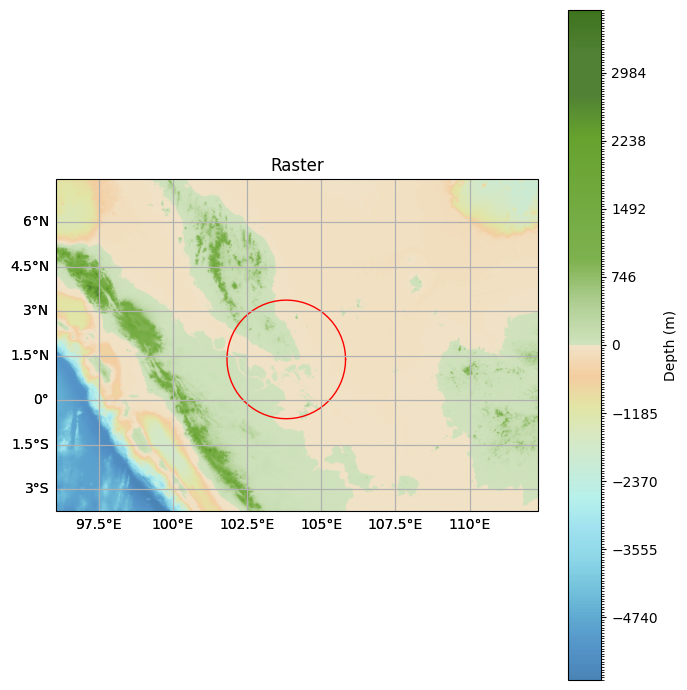

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from bluemath_tk.topo_bathy.mesh_utils import plot_bathymetry
from pyproj import CRS
from shapely.geometry import Polygon

domain_crs = CRS.from_user_input("epsg:4326")
domain_polygon = Polygon(point.buffer(2).exterior.coords)


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_bathymetry(rasters_path=initial_raster_paths, polygon=domain_polygon, ax=ax)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.tight_layout()
plt.show()

### Final Bathymetry Clipping and representation, calcul of the raster resolution for a future resampling

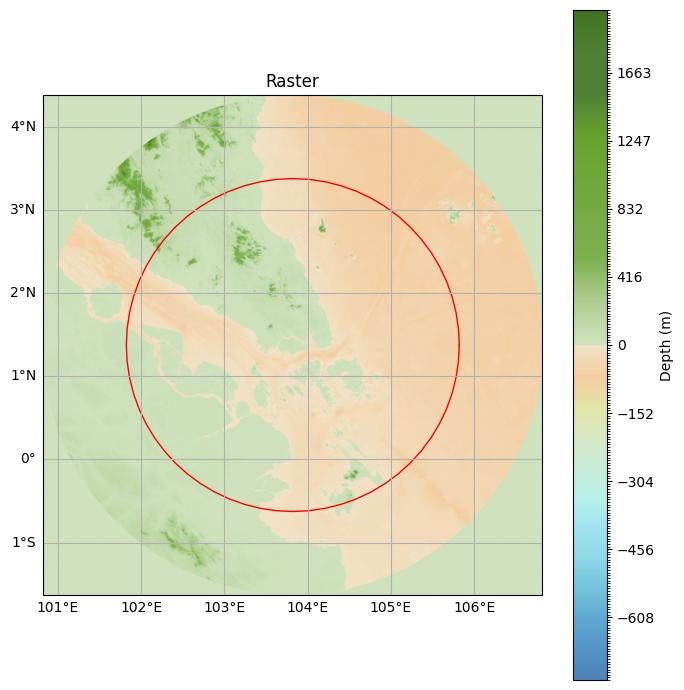

In [6]:
from bluemath_tk.topo_bathy.mesh_utils import (
    clip_bathymetry,
    get_raster_resolution_meters,
)

raster_resolution = clip_bathymetry(
    input_raster_paths=initial_raster_paths,
    output_path=output_bathy_clip_tif_path,
    domain=domain_polygon,
    margin=1,
)

raster_resolution_meters = get_raster_resolution_meters(
    lon_center=lon_center,
    lat_center=lat_center,
    raster_resolution=raster_resolution,
    project=project,
)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_bathymetry(clipped_raster_paths, domain_polygon, ax)
plt.tight_layout()
plt.show()

## Computacional grid generation

### Define the boundary of the area of interest using a polygon generated from an elevation threshold applied to the bathymetry raster.

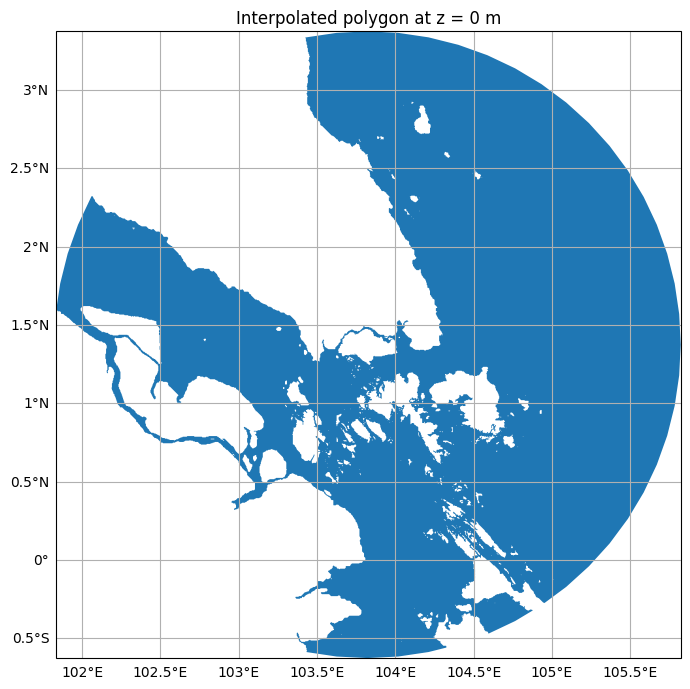

In [7]:
import geopandas as gpd
import ocsmesh
from shapely.geometry import MultiPolygon

Mean_Sea_Level = 0

rasters = [ocsmesh.Raster(path) for path in clipped_raster_paths]
coastal_area = ocsmesh.Geom(rasters, zmax=Mean_Sea_Level).get_multipolygon()
intersected = coastal_area.intersection(domain_polygon)
if isinstance(intersected, MultiPolygon):
    intersected_area = max(intersected.geoms, key=lambda p: p.area)
else:
    intersected_area = intersected

gdf = gpd.GeoSeries([intersected_area], crs="EPSG:4326")
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
minx, miny, maxx, maxy = gdf.total_bounds
gdf.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_title(f"Interpolated polygon at z = {Mean_Sea_Level} m")
ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.tight_layout()
plt.show()

### Define mesh target size criteria

In [ ]:
gdf = gpd.read_file("inputs/polygon_detail.shp")
poly_detail = gdf.geometry.iloc[0]

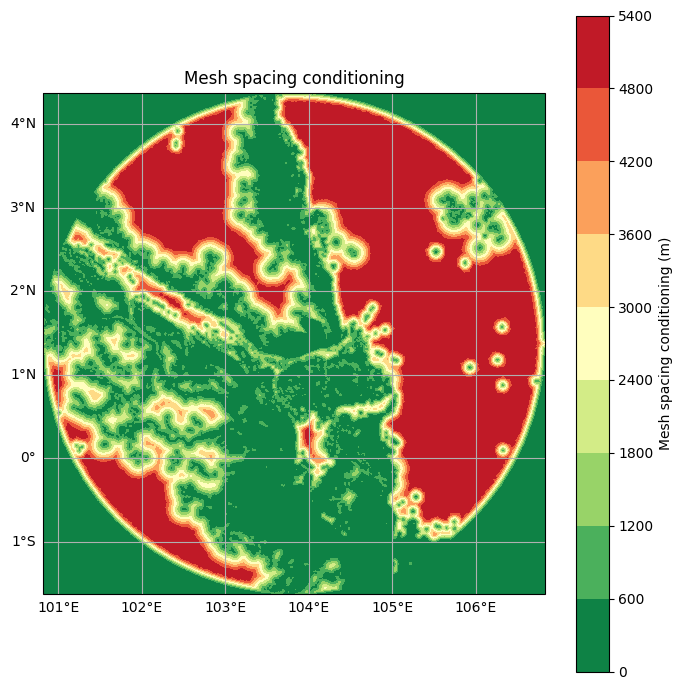

In [9]:
from bluemath_tk.topo_bathy.mesh_utils import define_mesh_target_size, plot_mesh_vals

geometry = ocsmesh.Geom(
    [],
    base_shape=intersected_area,
    base_shape_crs=domain_crs,
)
domain_multipolygon = geometry.get_multipolygon()

# Define depth zones with mesh size and transition rate per range
# Format: (lower_bound, upper_bound): {'value': mesh_size, 'rate': expansion_rate}
expention_rate = 0.0008
depth_ranges = {
    (-200_000, -150): {"value": 5000, "rate": expention_rate},  # Very deep ocean
    (-25, 2.5): {"value": 500, "rate": expention_rate},  # Coastal zone
    (2.5, 10): {"value": 250, "rate": expention_rate},  # Shallow coastal zone
}

mesh_spacing = define_mesh_target_size(
    rasters=rasters,
    raster_resolution_meters=raster_resolution_meters,
    depth_ranges=depth_ranges,
    nprocs=16,
)

mesh_spacing.add_region_constraint(250, poly_detail, "EPSG:4326", 'max',0.002)

mesh_spacing_field = mesh_spacing.msh_t()

CRS_OCS = mesh_spacing_field.crs
to_LL = pyproj.Transformer.from_crs(CRS_OCS, "EPSG:4326", always_xy=True).transform

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_vals(msh_t=mesh_spacing_field, ax=ax, to_geo=to_LL, cmap="RdYlGn_r")
ax.set_title("Mesh spacing conditioning")
plt.tight_layout()

### Mesh generation

In [10]:
driver = ocsmesh.JigsawDriver(geom=geometry, hfun=mesh_spacing, initial_mesh=False)
mesh = driver.run(remesh_tiny_elements=True)
mesh.interpolate(raster=rasters, method="linear")

## Problematic elements gestion

In [11]:
from bluemath_tk.topo_bathy.OCSMod import EuclideanMesh2D

copy_mesh = EuclideanMesh2D(mesh.msh_t)
data_mesh = copy_mesh.vert2
node_coords = np.array([item["coord"] for item in data_mesh])
elements = np.array(list(ocsmesh.utils.elements(mesh.msh_t).values()))

### Application of the criterion to detect problematic elements

In [14]:
from bluemath_tk.core.geo import buffer_area_for_polygon, mask_points_outside_polygon
from bluemath_tk.topo_bathy.mesh_utils import detect_circumcenter_too_close
from pyproj.enums import TransformDirection
from shapely.ops import transform

CRS_OCS = mesh.crs
to_LL = pyproj.Transformer.from_crs(CRS_OCS, "EPSG:4326", always_xy=True).transform


def to_geo(x, y):
    return to_LL(x, y, direction=TransformDirection.INVERSE)


intersected_area_UTM = Polygon(
    transform(to_geo, intersected_area).exterior.coords
)  # only clean boondary
# intersected_area_UTM = transform(to_geo, intersected_area)                              # clean island too
intersected_area_UTM_extended = buffer_area_for_polygon(
    polygon=intersected_area_UTM, area_factor=0.0001
)

mask_generation_outside = mask_points_outside_polygon(
    elements=elements, node_coords=node_coords, poly=intersected_area_UTM_extended
)
print(f"Number of elements outside the polygon: {mask_generation_outside.sum()}")

mask_circumcenter = detect_circumcenter_too_close(
    X=node_coords[:, 0], Y=node_coords[:, 1], elements=elements, aj_threshold=0.1
)
print(f"Number of elements with circumcenter too close: {mask_circumcenter.sum()}")

complete_mask = mask_generation_outside | mask_circumcenter

Number of elements outside the polygon: 0
Number of elements with circumcenter too close: 130


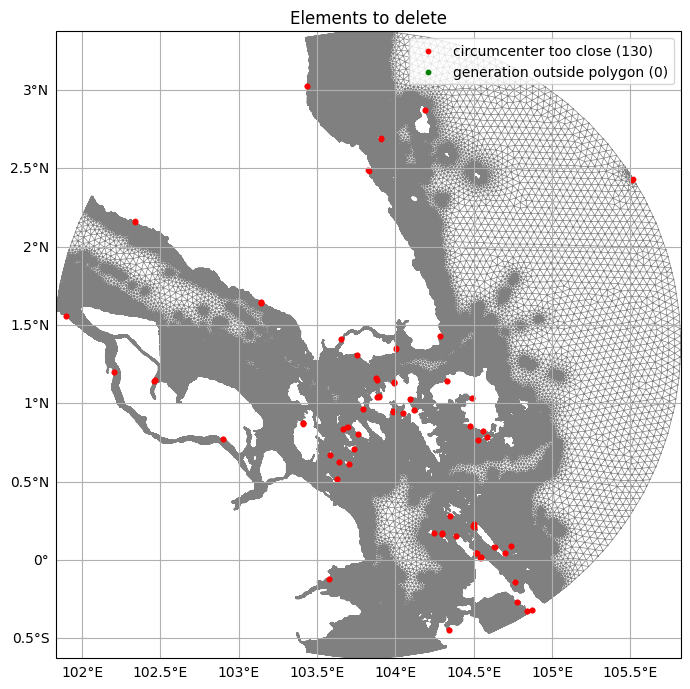

In [15]:
from bluemath_tk.topo_bathy.mesh_utils import plot_mesh_edge

bad_elements_generation = np.mean(
    node_coords[elements[mask_generation_outside]], axis=1
)
bad_elements_circumcenter = np.mean(node_coords[elements[mask_circumcenter]], axis=1)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_edge(msh_t=copy_mesh.msh_t, to_geo=to_LL, ax=ax, color="gray", lw=0.5)


ax.scatter(
    *to_LL(
        bad_elements_circumcenter[:, 0].flatten(),
        bad_elements_circumcenter[:, 1].flatten(),
    ),
    color="red",
    s=10,
    label=f"circumcenter too close ({mask_circumcenter.sum()})",
)
ax.scatter(
    *to_LL(
        bad_elements_generation[:, 0].flatten(), bad_elements_generation[:, 1].flatten()
    ),
    color="green",
    s=10,
    label=f"generation outside polygon ({mask_generation_outside.sum()})",
)

ax.set_title("Elements to delete")
ax.legend()
plt.tight_layout()

### Clean the problematic elements

In [16]:
cleaned_mesh = ocsmesh.utils.clip_elements_by_index(
    copy_mesh, tria=complete_mask, quad=None
)
ocsmesh.utils.finalize_mesh(cleaned_mesh)

### Batimetry interpolation and plotting

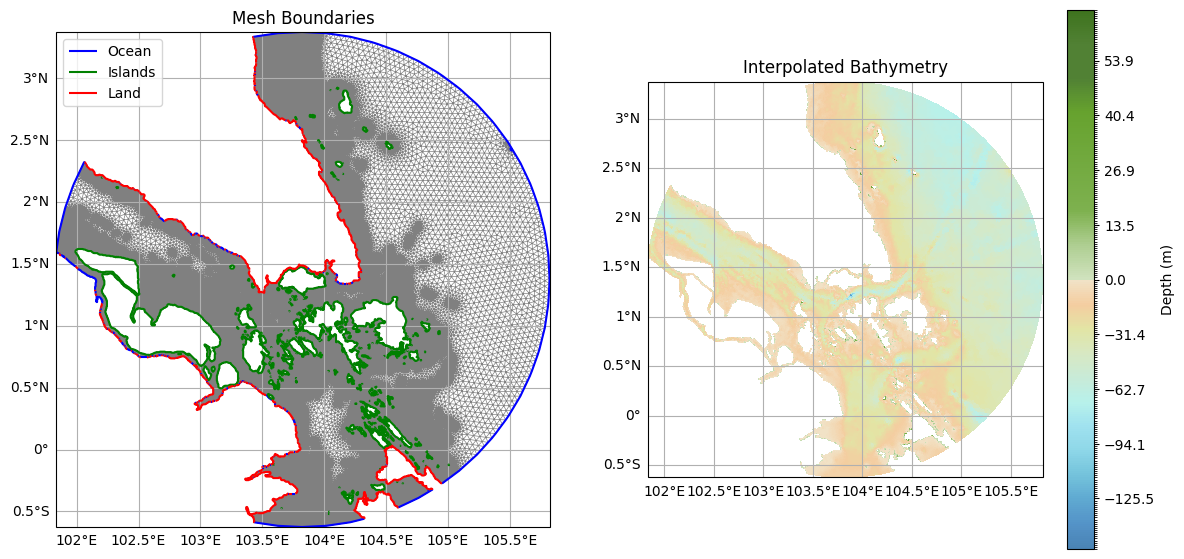

In [17]:
from bluemath_tk.topo_bathy.mesh_utils import plot_bathymetry_interp, plot_boundaries

cleaned_mesh.interpolate(rasters, method="linear")
cleaned_mesh.boundaries.auto_generate(Mean_Sea_Level)

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(figsize[0] * 2, figsize[1]),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

plot_boundaries(mesh=cleaned_mesh, to_geo=to_LL, ax=ax1)
plot_bathymetry_interp(mesh=cleaned_mesh, to_geo=to_LL, ax=ax2)

### Mesh saving

In [18]:
path_grd_calc = f"outputs/mesh_{site}_Calc_adcirc.grd"
cleaned_mesh.write(path_grd_calc, format="grd", overwrite=True)

### Convert from ADCIRC to NetCDF compatible with Delft3DFM

In [19]:
from bluemath_tk.topo_bathy.mesh_utils import adcirc2DFlowFM

netcdf_path = f"templates/mesh_{site}_net.nc"
adcirc2DFlowFM(Path_grd=path_grd_calc, netcdf_path=netcdf_path)